# Libraries

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
import time
from tqdm import trange
import scipy.optimize as sciOp
from scipy.optimize import curve_fit

# Hyperparameters

In [16]:
c1=0.4; c2=1-c1; T21=75; T22=80; T11=150; T12=450
N=51
t=np.linspace(0,500,N)

TI_star_1 = np.log(2)*T11
TI_star_2 = np.log(2)*T12
TI_star_1_vec = np.linspace(TI_star_1-30, TI_star_1+30, 61)
TI_star_2_vec = np.linspace(TI_star_2-30, TI_star_2+30, 61)

SNR_select = 100

#design matrix D
col1=np.ones(N); col2=t
D=np.asarray([col1,col2]).T

# Functions

In [17]:
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def S_moX_3p(T_dat, c, T1, T2):
    TE, TI = T_dat
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_6p(TE, TI, c1, c2, T21, T22,  T11, T12):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

In [18]:
def PInv(D):   
    PInv=   np.dot(np.linalg.inv(np.dot(D.T,D)), D.T)
    return(PInv)

In [19]:
def estimate_NLLS(func, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(func, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)

    popt = check_param_order(popt,func)
        
    return popt

def check_param_order(popt, func):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    
    f_name = func.__name__
    num = 0
    if 'off' in f_name:
        num = -1

    if (popt[-2+num] > popt[-1+num]): #We want by convention to make sure that T21 is <= T22
        for i in range(popt.shape[0]//2):
            p_hold = popt[2*i]
            popt[2*i] = popt[2*i+1]
            popt[2*i+1] = p_hold
    return popt

def add_noise(data, SNR):
    sigma = np.max(np.abs(data))/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    return data + noise

# Generate Data

In [20]:
data_TI_star_1=['']*len(TI_star_1_vec)
log_data_TI_star_1=['']*len(TI_star_1_vec)
for kk in range(len(TI_star_1_vec)):
#     print(kk)
    data_TI_star_1[kk]=S_biX_6p(t, TI_star_1_vec[kk], c1, c2, T21, T22, T11, T12)
    if (all(val < 0 for val in data_TI_star_1[kk]) or all(val > 0 for val in data_TI_star_1[kk]))==False:
        pass
#         print('Data changes sign; cannot analyze')
    if all(val < 0 for val in data_TI_star_1[kk])==True:
        pass
#         print(f'Data for kk={kk}, TI = {TI_vect[kk]} is all negative so will take abs value\n')
        data_TI_star_1[kk]=-data_TI_star_1[kk]
    log_data_TI_star_1[kk]=np.log(data_TI_star_1[kk])

In [ ]:
data_TI_star_2 = ['']*len(TI_star_2_vec)
log_data_TI_star_2 = ['']*len(TI_star_2_vec)
for kk in range(len(TI_star_2_vec)):
#     print(kk)
    data_TI_star_2[kk]=S_biX_6p(t, TI_star_2_vec[kk], c1, c2, T21, T22, T11, T12)
    if (all(val < 0 for val in data_TI_star_2[kk]) or all(val > 0 for val in data_TI_star_2[kk]))==False:
        pass
#         print('Data changes sign; cannot analyze')
    if all(val < 0 for val in data_TI_star_2[kk])==True:
        pass
#         print(f'Data for kk={kk}, TI = {TI_vect[kk]} is all negative so will take abs value\n')
        data_TI_star_2[kk]=-data_TI_star_2[kk]
    log_data_TI_star_2[kk]=np.log(data_TI_star_2[kk])

In [21]:
coeffs_log_nl=np.zeros(len(TI_vect)); tau_consts_log_nl=np.zeros(len(TI_vect))
RSS_log_nl = np.zeros(len(TI_vect))
coeffs_NLLS_nl =np.zeros(len(TI_vect)); tau_consts_NLLS_nl =np.zeros(len(TI_vect))
RSS_NLLS_nl = np.zeros(len(TI_vect))

print(f'Nulling value for TI = {TI_star_1}')

for kk in range(len(TI_vect)):
    parms_log=np.dot(PInv(D),log_data_TI[kk])
    coeffs_log_nl[kk]=np.exp(parms_log[0])
    tau_consts_log_nl[kk]=-1/parms_log[1]

    RSS_log_nl[kk] = np.sum((data_TI[kk] - S_moX_2p(t, coeffs_log_nl[kk], tau_consts_log_nl[kk]))**2)

    popt = estimate_NLLS(S_moX_2p, t, data_TI[kk], [0.5, 60], [0,1], [40, 140])
    coeffs_NLLS_nl[kk] = popt[0]
    tau_consts_NLLS_nl[kk] = popt[1]
    RSS_NLLS_nl[kk] = np.sum((data_TI[kk] - S_moX_2p(t, coeffs_NLLS_nl[kk], tau_consts_NLLS_nl[kk]))**2)


Nulling value for TI = 103.97207708399179


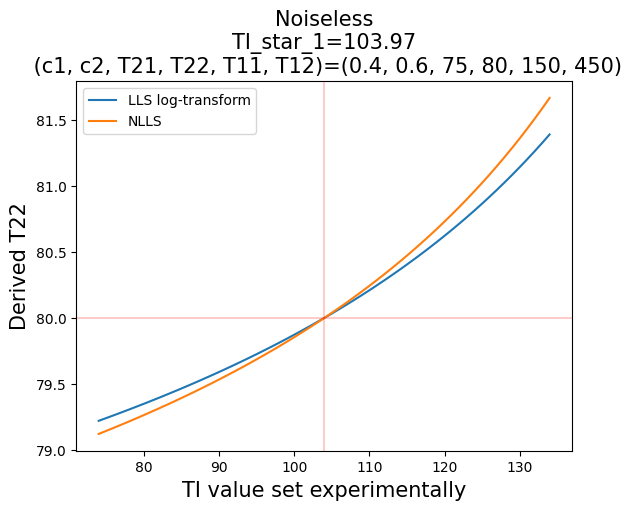

In [22]:
plt.plot(TI_vect,tau_consts_log_nl, label = 'LLS log-transform')
plt.plot(TI_vect,tau_consts_NLLS_nl, label = 'NLLS')
plt.title(f'Noiseless\nTI_star_1={np.round(TI_star_1,2)}\n (c1, c2, T21, T22, T11, T12)={c1,c2,T21,T22,T11,T12}', fontsize=15, color='black')
plt.axhline(y = T22, color = 'r', linestyle = '-', alpha=0.2)
plt.axvline(x=TI_star_1, color='r', linestyle = '-', alpha=0.2)
plt.xlabel("TI value set experimentally", fontsize=15)
plt.ylabel('Derived T22',fontsize=15)
plt.legend()

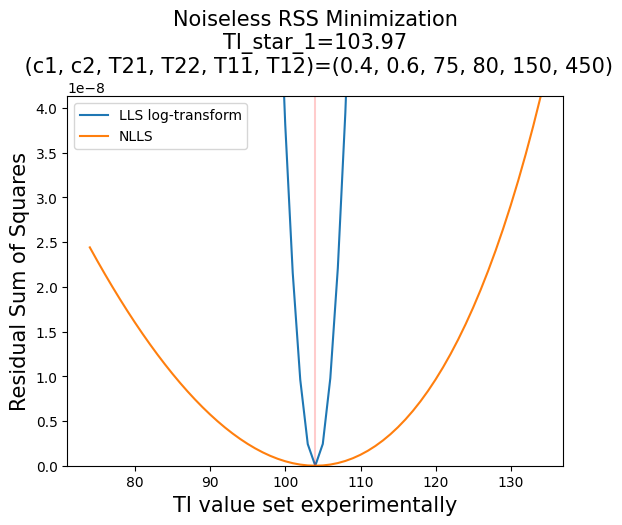

In [23]:
plt.plot(TI_vect,RSS_log_nl, label = 'LLS log-transform')
plt.plot(TI_vect,RSS_NLLS_nl, label = 'NLLS')
plt.title(f'Noiseless RSS Minimization\nTI_star_1={np.round(TI_star_1,2)}\n (c1, c2, T21, T22, T11, T12)={c1,c2,T21,T22,T11,T12}', fontsize=15, color='black')
plt.axvline(x=TI_star_1, color='r', linestyle = '-', alpha=0.2)
plt.xlabel("TI value set experimentally", fontsize=15)
plt.ylabel('Residual Sum of Squares',fontsize=15)
plt.ylim([0,np.max(RSS_NLLS_nl)])
plt.legend()

# Adding Noise

In [24]:
data_TI=['']*len(TI_vect)
log_data_TI=['']*len(TI_vect)
for kk in range(len(TI_vect)):
#     print(kk)
    data_TI[kk]=S_biX_6p(t, TI_vect[kk], c1, c2, T21, T22, T11, T12)
    if (all(val < 0 for val in data_TI[kk]) or all(val > 0 for val in data_TI[kk]))==False:
        pass
#         print('Data changes sign; cannot analyze')
    if all(val < 0 for val in data_TI[kk])==True:
        pass
#         print(f'Data for kk={kk}, TI = {TI_vect[kk]} is all negative so will take abs value\n')
        data_TI[kk]=-data_TI[kk]
    data_TI[kk]=add_noise(data_TI[kk], SNR_select)
    log_data_TI[kk]=np.log(data_TI[kk])

C:\Users\griff\AppData\Local\Temp\ipykernel_29380\2046973797.py:14: RuntimeWarning: invalid value encountered in log
  log_data_TI[kk]=np.log(data_TI[kk])


In [25]:
coeffs_log=np.zeros(len(TI_vect)); tau_consts_log=np.zeros(len(TI_vect))
RSS_log = np.zeros(len(TI_vect))
coeffs_NLLS=np.zeros(len(TI_vect)); tau_consts_NLLS=np.zeros(len(TI_vect))
RSS_NLLS = np.zeros(len(TI_vect))

print(f'Nulling value for TI = {TI_star_1}')

for kk in range(len(TI_vect)):
    parms_log=np.dot(PInv(D),log_data_TI[kk])
    coeffs_log[kk]=np.exp(parms_log[0])
    tau_consts_log[kk]=-1/parms_log[1]

    RSS_log[kk] = np.sum((data_TI[kk] - S_moX_2p(t, coeffs_log[kk], tau_consts_log[kk]))**2)

    popt = estimate_NLLS(S_moX_2p, t, data_TI[kk], [0.5, 60], [0,1], [40, 140])
    coeffs_NLLS[kk] = popt[0]
    tau_consts_NLLS[kk] = popt[1]
    RSS_NLLS[kk] = np.sum((data_TI[kk] - S_moX_2p(t, coeffs_NLLS[kk], tau_consts_NLLS[kk]))**2)


Nulling value for TI = 103.97207708399179


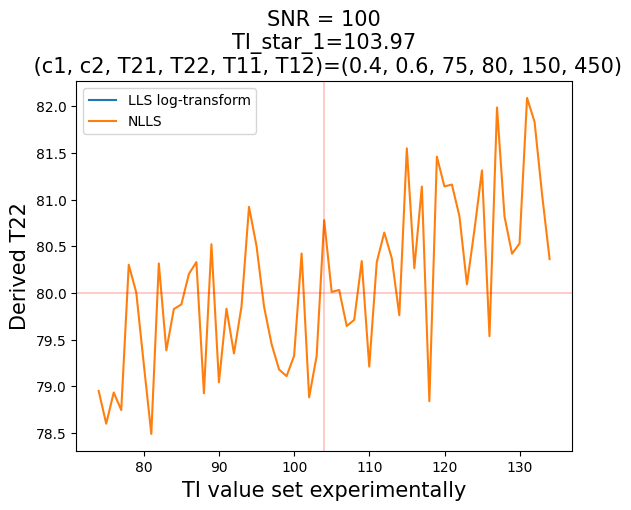

In [26]:
plt.plot(TI_vect,tau_consts_log, label = 'LLS log-transform')
plt.plot(TI_vect,tau_consts_NLLS, label = 'NLLS')
plt.title(f'SNR = {SNR_select}\nTI_star_1={np.round(TI_star_1,2)}\n (c1, c2, T21, T22, T11, T12)={c1,c2,T21,T22,T11,T12}', fontsize=15, color='black')
plt.axhline(y = T22, color = 'r', linestyle = '-', alpha=0.2)
plt.axvline(x=TI_star_1, color='r', linestyle = '-', alpha=0.2)
plt.xlabel("TI value set experimentally", fontsize=15)
plt.ylabel('Derived T22',fontsize=15)
plt.legend()

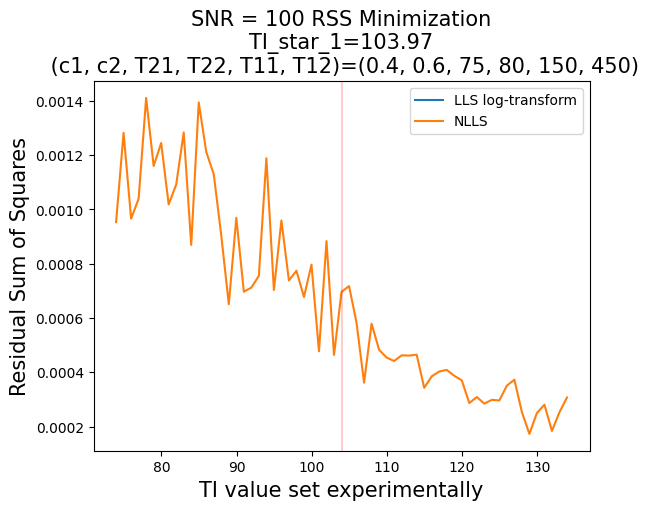

In [27]:
plt.plot(TI_vect,RSS_log, label = 'LLS log-transform')
plt.plot(TI_vect,RSS_NLLS, label = 'NLLS')
plt.title(f'SNR = {SNR_select} RSS Minimization\nTI_star_1={np.round(TI_star_1,2)}\n (c1, c2, T21, T22, T11, T12)={c1,c2,T21,T22,T11,T12}', fontsize=15, color='black')
plt.axvline(x=TI_star_1, color='r', linestyle = '-', alpha=0.2)
plt.xlabel("TI value set experimentally", fontsize=15)
plt.ylabel('Residual Sum of Squares',fontsize=15)
plt.legend()

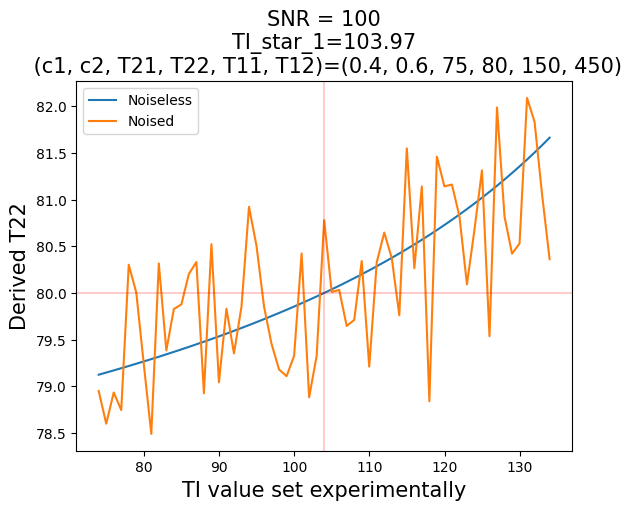

In [28]:
plt.plot(TI_vect,tau_consts_NLLS_nl, label = 'Noiseless')
plt.plot(TI_vect,tau_consts_NLLS, label = 'Noised')
plt.title(f'SNR = {SNR_select}\nTI_star_1={np.round(TI_star_1,2)}\n (c1, c2, T21, T22, T11, T12)={c1,c2,T21,T22,T11,T12}', fontsize=15, color='black')
plt.axhline(y = T22, color = 'r', linestyle = '-', alpha=0.2)
plt.axvline(x=TI_star_1, color='r', linestyle = '-', alpha=0.2)
plt.xlabel("TI value set experimentally", fontsize=15)
plt.ylabel('Derived T22',fontsize=15)
plt.legend()